In [173]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import binom
import qiskit 
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, execute


$$\left|\psi(t) \right\rangle = e^{-iHt} \left|\psi(0) \right\rangle$$

We can use Trotter approximation: 
$$e^{iHt} \approx \big(\prod_k e^{i c_k P_k t/N }\big)^{N}$$

$$H = \sum_{i=1}^{n-1} X_i \otimes \left( n_{i-1} n'_{i+1} + n'_{i-1} n_{i+1} \right), \quad \text{where} \quad n_j = \frac{I - Z_j}{2}, \quad n'_j = \frac{I + Z_j}{2}.$$

$$
H = \sum_{i=1}^{n-1} X_i \otimes \left( \frac{I - Z_{i-1}}{2} \frac{I + Z_{i+1}}{2} + \frac{I + Z_{i-1}}{2} \frac{I - Z_{i+1}}{2} \right)
$$
$$
= \sum_{i=1}^{n-1} X_i \otimes \left( \frac{I \otimes I - I \otimes Z_{i+1} + Z_{i-1} \otimes I - Z_{i-1} \otimes Z_{i+1} + I \otimes I + I \otimes Z_{i+1} - Z_{i-1} \otimes I + Z_{i-1} \otimes Z_{i+1}}{4} \right)
$$


$$
H = \sum_{i=1}^{n-1} \frac{1}{4}( X_i  -  X_i \otimes Z_{i+1}   +  Z_{i-1} \otimes X_i - Z_{i-1} \otimes X_i \otimes Z_{i+1} + X_i  +  X_i \otimes Z_{i+1}   -  Z_{i-1} \otimes X_i - Z_{i-1} \otimes X_i \otimes Z_{i+1})
$$

$$
= \sum_{i=1}^{n-1} X_i \otimes \left( \frac{2 * I \otimes I - 2* Z_{i-1} \otimes Z_{i+1}}{4} \right)
$$

In [201]:
hamiltonian = {

    "IXI": 0.5, # X on qubit 1, I on others
    "ZXZ": -0.5,
    # "XII": 0.5, # X on qubit 2, I on others
    # "XZZ": -0.5,
    # "IIX": 0.5, # X on qubit 3, I on others
    # "ZZX": -0.5
}


In [202]:
def exp_all_z(circuit, quantum_register, 
              pauli_idexes, control_qubit=None, t=1):
    """
    Implements the exponential of a product of Z gates on a quantum circuit.
    :param circuit: QuantumCircuit.
    :param quantum_register: QuantumRegister.
    :param pauli_idexes: Indexes of qubits on which Z gates are applied.
    :param control_qubit: Optional control qubit for a controlled operation.
    :param t: Coefficient for the exponent.
    """

    # the controlled_exp(iIt) special case
    if len(pauli_idexes) == 0 and control_qubit is not None:
        circuit.add_register(control_qubit.register)
        circuit.u1(t, control_qubit)
        return
        
    # the first CNOTs
    for i in range(len(pauli_idexes) - 1):
        circuit.cx(quantum_register[pauli_idexes[i]],
                   quantum_register[pauli_idexes[i + 1]])
    
    # Rz gate
    if control_qubit is None:
        circuit.rz(-2 * t, quantum_register[pauli_idexes[-1]])
    else:
        circuit.add_register(control_qubit.register)
        circuit.crz(-2 * t, 
                    control_qubit, quantum_register[pauli_idexes[-1]])
    
    # the second CNOTs
    for i in reversed(range(len(pauli_idexes) - 1)):
        circuit.cx(quantum_register[pauli_idexes[i]],
                   quantum_register[pauli_idexes[i + 1]])





def exp_pauli(pauli, quantum_register, control_qubit=None, t=1):
    """
    The circuit for the exp(i P t), where P is the Pauli term, 
    t is the parameter.
    :param pauli: the string for the Pauli term: e.g. "XIXY".
    :param quantum_register: QuantumRegister.
    :param control_qubit: the control Qubit from QuantumRegister 
                          other than quantum_register.
    :param t: the parameter t in exp(i P t).
    :return: QuantumCircuit that implements exp(i P t) or 
             control version of it.
    """
    if len(pauli) != len(quantum_register):
        raise Exception("Pauli string doesn't match to the quantum register")

    pauli_circuit = QuantumCircuit(quantum_register)
    circuit_bracket = QuantumCircuit(quantum_register)
    pauli_idexes = []

    for i in range(len(quantum_register)):
        if pauli[i] == 'I':
            continue
        elif pauli[i] == 'Z':
            pauli_idexes.append(i)
        elif pauli[i] == 'X':
            circuit_bracket.h(quantum_register[i])
            pauli_idexes.append(i)
        elif pauli[i] == 'Y':
            circuit_bracket.u(np.pi / 2, np.pi / 2, np.pi / 2, quantum_register[i])
            pauli_idexes.append(i)

    pauli_circuit &= circuit_bracket
    exp_all_z(pauli_circuit, quantum_register, pauli_idexes, control_qubit, t)
    pauli_circuit &= circuit_bracket

    return pauli_circuit





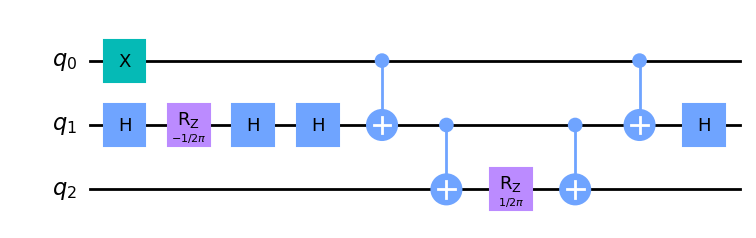

In [203]:

def hamiltonian_simulation(hamiltonian, quantum_register=None, 
                           control_qubit=None, t=1, trotter_number=1):
    """
    The implementation of exp(iHt), where H is the Hamiltonian 
    operator, t is the parameter.
    """
    if quantum_register is None:
        quantum_register = QuantumRegister(len(list(hamiltonian.keys())[0]))
    if control_qubit in quantum_register:
        raise Exception("the control qubit is in the target register")

    delta_t = t / trotter_number
    exp_hamiltonian = QuantumCircuit(quantum_register)
    exp_delta_t = QuantumCircuit(quantum_register)

    for pauli in hamiltonian:
        weight = hamiltonian[pauli]
        exp_pauli_circuit = exp_pauli(pauli, quantum_register, control_qubit, weight * delta_t)
        exp_delta_t.compose(exp_pauli_circuit, qubits=range(len(exp_hamiltonian.qubits)), inplace=True)

    for i in range(trotter_number):
        exp_hamiltonian.compose(exp_delta_t, inplace=True)

    return exp_hamiltonian

# Create a quantum circuit for the Hamiltonian simulation
num_qubits = 3
quantum_register = QuantumRegister(num_qubits, 'q')

# Initialize the circuit with the quantum register
circuit = QuantumCircuit(quantum_register)

# Apply X gate to the first qubit
circuit.x(quantum_register[0])

# Now call the hamiltonian_simulation function with the circuit
circuit &= hamiltonian_simulation(hamiltonian, quantum_register, t=1/(2*np.pi))

# Draw the circuit
circuit.draw(output="mpl")



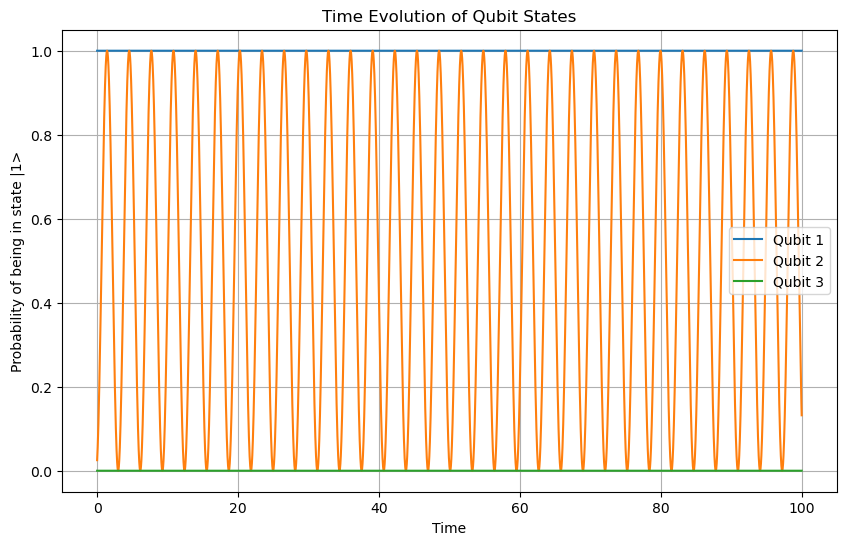

In [205]:


# Time parameters
time_steps = np.linspace(0, 100, 5000)  # Adjust the range and step size as needed
trotter_steps = 10  # Adjust the Trotter step count as needed

# To store the state probabilities
probabilities = np.zeros((len(time_steps), 3))

# Initialize the simulator
simulator = Aer.get_backend('statevector_simulator')

# Simulate the circuit for each time step
for idx, time in enumerate(time_steps):
    temp_circuit = circuit.copy()
    temp_circuit &= hamiltonian_simulation(hamiltonian, qr, t=time, trotter_number=trotter_steps)

    # Transpile the circuit for the simulator
    transpiled_circuit = transpile(temp_circuit, simulator)

    # Execute the transpiled circuit using the simulator
    job = simulator.run(transpiled_circuit)
    result = job.result()
    statevector = np.asarray(result.get_statevector())

    # Calculate probabilities for each qubit being in |1>
    for qubit in range(3):
        # Initialize probability to 0
        prob = 0
        # Iterate over all states
        for state in range(len(statevector)):
            # Check if the qubit is in state |1> in this state
            if (state >> qubit) % 2 == 1:
                prob += np.abs(statevector[state])**2
        probabilities[idx, qubit] = prob

# Plotting the results
plt.figure(figsize=(10, 6))
for qubit in range(3):
    plt.plot(time_steps, probabilities[:, qubit], label=f'Qubit {qubit+1}')
plt.xlabel('Time')
plt.ylabel('Probability of being in state |1>')
plt.title('Time Evolution of Qubit States')
plt.legend()
plt.grid(True)
plt.show()
